In [ ]:
%pip install fast_ml
%pip install ydata_profiling
%pip install lazypredict

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 KB 1.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 344.9/344.9 KB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 77.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.7/102.7 KB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 KB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.8/33.8 MB 41.6 MB/s eta 0:00:00
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.65.0
    Uninstalling tqdm-4.65.0:
      Successfully uninstalled tqdm-4.65.0
  Attempting uninstall: scipy
    Found existing installation: scipy 1.10.1
    Uninstalling scipy-1.10.1:
      Successfully uninstalled scipy-1.10.1
  Attempting uninsta

In [ ]:
#load packages
from ydata_profiling import ProfileReport
import seaborn as sns
import pandas as pd
import lazypredict
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from fast_ml.model_development import train_valid_test_split

In [ ]:
# Access data using Google BigQuery.
from google.colab import auth
from google.cloud import bigquery

# the below variables are used throughout the notebook - do not change them!
subject_ids = [10000032, 10001884, 10002223, 10002495, 10002443, 10003400, 10005866]
id_str = ','.join([str(s) for s in subject_ids])

# You only need to authenticate once per session.
auth.authenticate_user()

In [ ]:
# Import libraries
from datetime import timedelta
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# below imports are used for pretty pandas dataframes and plots
from IPython.display import display, HTML
%matplotlib inline
plt.style.use('ggplot')

# Set up environment variables
project_id = 'mimic-iv-thesis'
os.environ["GOOGLE_CLOUD_PROJECT"] = project_id

# Read data from BigQuery into pandas dataframes.
def run_query(query, project_id=project_id):
    return pd.io.gbq.read_gbq(
        query,
        project_id=project_id,
        dialect="standard"
    )

if project_id == 'CHANGE-ME':
  raise ValueError('You must change project_id to your GCP project at the top of this cell.')

# test it works
df = run_query("""
SELECT *
FROM `physionet-data.mimiciv_hosp.admissions`
WHERE subject_id = 10012853
""")
assert df.shape[0] >= 1, 'unable to query MIMIC!'
display(df)

# bigquery connection works!

subject_id   hadm_id           admittime           dischtime deathtime  \
0    10012853  20457729 2177-11-03 09:30:00 2177-11-04 15:06:00       NaT   
1    10012853  26739864 2177-02-11 07:15:00 2177-02-12 16:20:00       NaT   
2    10012853  22539296 2176-06-06 18:09:00 2176-06-08 18:30:00       NaT   
3    10012853  27882036 2176-11-25 21:28:00 2176-12-03 15:24:00       NaT   
4    10012853  26369609 2175-04-05 15:36:00 2175-04-10 16:55:00       NaT   
5    10012853  22896692 2176-08-11 15:17:00 2176-08-11 17:35:00       NaT   

       admission_type admit_provider_id  admission_location  \
0  DIRECT OBSERVATION            P05BRR  PHYSICIAN REFERRAL   
1  DIRECT OBSERVATION            P05BRR  PHYSICIAN REFERRAL   
2            EW EMER.            P172D4      EMERGENCY ROOM   
3            EW EMER.            P450WM      EMERGENCY ROOM   
4            EW EMER.            P623U2      EMERGENCY ROOM   
5      EU OBSERVATION            P76VMW      EMERGENCY ROOM   

         discharge_location insurance language marital_status  \
0                      None  Medicare  ENGLISH        WIDOWED   
1                      None  Medicare  ENGLISH        WIDOWED   
2                      HOME  Medicare  ENGLISH        WIDOWED   
3  SKILLED NURSING FACILITY  Medicare  ENGLISH        WIDOWED   
4                      HOME     Other  ENGLISH        WIDOWED   
5                      None  Medicare  ENGLISH        WIDOWED   

                     race           edregtime           edouttime  \
0  BLACK/AFRICAN AMERICAN                 NaT                 NaT   
1  BLACK/AFRICAN AMERICAN                 NaT                 NaT   
2  BLACK/AFRICAN AMERICAN 2176-06-06 13:33:00 2176-06-06 20:18:00   
3  BLACK/AFRICAN AMERICAN 2176-11-25 18:34:00 2176-11-25 23:51:00   
4  BLACK/AFRICAN AMERICAN 2175-04-05 06:22:00 2175-04-05 17:10:00   
5  BLACK/AFRICAN AMERICAN 2176-08-11 08:36:00 2176-08-11 17:35:00   

   hospital_expire_flag  
0                     0  
1                     0  
2                     0  
3                     0  
4                     0  
5                     0

In [ ]:
#create dataframe from query based on ICD codes diagnoses
criteria_df = run_query("""
SELECT * FROM
  (SELECT *
    FROM `physionet-data.mimiciv_hosp.diagnoses_icd`
  WHERE `physionet-data.mimiciv_hosp.diagnoses_icd`.icd_code IN ('490', '4910', '4911', '4912', '49120', '49121', '49122', '4918', '4919', '4920', '4928', '494', '4940', '4941', '496')) a
  LEFT JOIN
  (SELECT *
  FROM `physionet-data.mimiciv_hosp.patients`
  WHERE `physionet-data.mimiciv_hosp.patients`.anchor_age >= 18 AND `physionet-data.mimiciv_hosp.patients`.anchor_age <= 91 ) b
  ON a.SUBJECT_ID = b.SUBJECT_ID
  LEFT JOIN
  (SELECT subject_id, MIN(admittime) as admittime_first
  FROM `physionet-data.mimiciv_hosp.admissions`
  GROUP BY subject_id) c
  ON b.SUBJECT_ID = c.SUBJECT_ID
""")
display(criteria_df)


subject_id   hadm_id  seq_num icd_code  icd_version  subject_id_1  \
0        14993854  23794293       26     4928            9      14993854   
1        15317980  20105809       35      496            9      15317980   
2        15317980  23377058       30      496            9      15317980   
3        10103318  22917647        1     4920            9      10103318   
4        10272619  23536707        1    49121            9      10272619   
...           ...       ...      ...      ...          ...           ...   
20311    19753029  22888975       24      496            9      19753029   
20312    19773589  21873816       24     4940            9      19773589   
20313    19956383  28981174       24      496            9      19956383   
20314    11208075  23432541       25     4940            9      11208075   
20315    13961236  27330206       25     4919            9      13961236   

      gender  anchor_age  anchor_year anchor_year_group         dod  \
0          M          42         2144       2011 - 2013  2150-05-20   
1          F          34         2150       2008 - 2010  2158-11-26   
2          F          34         2150       2008 - 2010  2158-11-26   
3          M          24         2158       2011 - 2013         NaT   
4          F          43         2162       2011 - 2013         NaT   
...      ...         ...          ...               ...         ...   
20311      M          91         2149       2014 - 2016  2149-07-11   
20312      M          91         2134       2008 - 2010  2136-09-06   
20313      F          91         2113       2011 - 2013  2113-02-15   
20314      F          91         2189       2011 - 2013  2192-04-16   
20315      M          91         2124       2008 - 2010  2126-09-05   

       subject_id_2     admittime_first  
0          14993854 2144-04-17 15:31:00  
1          15317980 2152-10-01 22:10:00  
2          15317980 2152-10-01 22:10:00  
3          10103318 2158-07-20 13:25:00  
4          10272619 2162-09-15 23:35:00  
...             ...                 ...  
20311      19753029 2149-03-27 03:23:00  
20312      19773589 2134-09-27 14:25:00  
20313      19956383 2113-02-12 18:38:00  
20314      11208075 2189-02-17 20:21:00  
20315      13961236 2124-06-01 17:25:00  

[20316 rows x 13 columns]

In [ ]:
#subset by specific columns
criteria_df_subet = criteria_df[['subject_id','gender', 'anchor_age','admittime_first']]
#can also do select subject_id, gender, anchor_age, admittime_first for prior query

In [ ]:
#adding admit time by length of stay
readmit_df = run_query("""
select * from
  (select subject_id, hadm_id, admittime, dischtime,
    rank() over(partition by subject_id order by admittime) as admittime_rank
  from `physionet-data.mimiciv_hosp.admissions`) a
  left join
  (select subject_id, max(admittime_rank) as max_admittime_rank from
  (select subject_id, hadm_id, admittime, dischtime,
    rank() over(partition by subject_id order by admittime) as admittime_rank
  from `physionet-data.mimiciv_hosp.admissions`)
  group by subject_id) b
  on a.subject_id = b.subject_id""")


In [ ]:
#print dataframe
readmit_df

subject_id   hadm_id           admittime           dischtime  \
0         10670085  26633059 2190-07-18 22:42:00 2190-07-19 03:26:00   
1         10670085  24126885 2192-05-24 06:51:00 2192-05-28 14:15:00   
2         10670085  24164808 2192-06-21 12:22:00 2192-06-26 20:44:00   
3         10670085  26806734 2192-08-03 14:13:00 2192-08-14 13:30:00   
4         10670085  27208257 2192-10-13 03:48:00 2192-10-22 17:04:00   
...            ...       ...                 ...                 ...   
431226    14875942  22834605 2201-02-11 11:50:00 2201-02-14 17:15:00   
431227    14875942  22287188 2201-06-18 21:13:00 2201-06-22 15:30:00   
431228    14875942  22490434 2202-01-09 22:34:00 2202-01-10 10:20:00   
431229    14875942  25716756 2202-12-05 10:35:00 2202-12-06 12:20:00   
431230    14875942  20568231 2204-03-01 14:45:00 2204-03-03 18:23:00   

        admittime_rank  subject_id_1  max_admittime_rank  
0                    1      10670085                  26  
1                    2      10670085                  26  
2                    3      10670085                  26  
3                    4      10670085                  26  
4                    5      10670085                  26  
...                ...           ...                 ...  
431226              18      14875942                  22  
431227              19      14875942                  22  
431228              20      14875942                  22  
431229              21      14875942                  22  
431230              22      14875942                  22  

[431231 rows x 7 columns]

In [ ]:
#format  the date and time
readmit_df[['admittime','dischtime']] = readmit_df[['admittime','dischtime']].apply(lambda x: pd.to_datetime(x, format='%Y-%m-%d %H:%M:%S'))

next_admittime = readmit_df['admittime'].values[1:]
next_admittime = np.append(next_admittime, next_admittime[0])
readmit_df['next_admittime'] = next_admittime

readmit_df['30_readmit'] = -1

readmit_df.loc[readmit_df['admittime_rank'] == readmit_df['max_admittime_rank'], '30_readmit'] = 0

readmit_sub_df = readmit_df[readmit_df['30_readmit']==-1]
interval = (readmit_sub_df['next_admittime'] - readmit_sub_df['dischtime']).dt.days.values
readmit_df.loc[readmit_df['30_readmit']==-1, 'interval'] = interval

readmit_df.loc[readmit_df['interval']<=30, '30_readmit'] = 1
readmit_df.loc[readmit_df['interval']>30, '30_readmit'] = 0

In [ ]:
#check what the final readmission dataframe looks like
readmit_df.head()


subject_id   hadm_id           admittime           dischtime  \
0    10670085  26633059 2190-07-18 22:42:00 2190-07-19 03:26:00   
1    10670085  24126885 2192-05-24 06:51:00 2192-05-28 14:15:00   
2    10670085  24164808 2192-06-21 12:22:00 2192-06-26 20:44:00   
3    10670085  26806734 2192-08-03 14:13:00 2192-08-14 13:30:00   
4    10670085  27208257 2192-10-13 03:48:00 2192-10-22 17:04:00   

   admittime_rank  subject_id_1  max_admittime_rank      next_admittime  \
0               1      10670085                  26 2192-05-24 06:51:00   
1               2      10670085                  26 2192-06-21 12:22:00   
2               3      10670085                  26 2192-08-03 14:13:00   
3               4      10670085                  26 2192-10-13 03:48:00   
4               5      10670085                  26 2192-11-06 20:39:00   

   30_readmit  interval  
0           0     675.0  
1           1      23.0  
2           0      37.0  
3           0      59.0  
4           1      15.0

In [ ]:
#make a separate dataframe for the 30 readmit flag with hadm id
readmit_label_df = readmit_df[['hadm_id', '30_readmit']]
readmit_label_df.head()

hadm_id  30_readmit
0  26633059           0
1  24126885           1
2  24164808           0
3  26806734           0
4  27208257           1

In [ ]:
#check the shape of the label dataframe
readmit_label_df.shape

(431231, 2)

In [ ]:
#get subject ids list
criteria_ids = criteria_df[['subject_id']]

In [ ]:
#mae a final dataframe based on overlapping ids
all_readmit_data= readmit_df[~(readmit_df.subject_id.isin(criteria_df.subject_id))]


In [ ]:
all_readmit_data

subject_id   hadm_id           admittime           dischtime  \
0         10670085  26633059 2190-07-18 22:42:00 2190-07-19 03:26:00   
1         10670085  24126885 2192-05-24 06:51:00 2192-05-28 14:15:00   
2         10670085  24164808 2192-06-21 12:22:00 2192-06-26 20:44:00   
3         10670085  26806734 2192-08-03 14:13:00 2192-08-14 13:30:00   
4         10670085  27208257 2192-10-13 03:48:00 2192-10-22 17:04:00   
...            ...       ...                 ...                 ...   
431226    14875942  22834605 2201-02-11 11:50:00 2201-02-14 17:15:00   
431227    14875942  22287188 2201-06-18 21:13:00 2201-06-22 15:30:00   
431228    14875942  22490434 2202-01-09 22:34:00 2202-01-10 10:20:00   
431229    14875942  25716756 2202-12-05 10:35:00 2202-12-06 12:20:00   
431230    14875942  20568231 2204-03-01 14:45:00 2204-03-03 18:23:00   

        admittime_rank  subject_id_1  max_admittime_rank      next_admittime  \
0                    1      10670085                  26 2192-05-24 06:51:00   
1                    2      10670085                  26 2192-06-21 12:22:00   
2                    3      10670085                  26 2192-08-03 14:13:00   
3                    4      10670085                  26 2192-10-13 03:48:00   
4                    5      10670085                  26 2192-11-06 20:39:00   
...                ...           ...                 ...                 ...   
431226              18      14875942                  22 2201-06-18 21:13:00   
431227              19      14875942                  22 2202-01-09 22:34:00   
431228              20      14875942                  22 2202-12-05 10:35:00   
431229              21      14875942                  22 2204-03-01 14:45:00   
431230              22      14875942                  22 2192-05-24 06:51:00   

        30_readmit  interval  
0                0     675.0  
1                1      23.0  
2                0      37.0  
3                0      59.0  
4                1      15.0  
...            ...       ...  
431226           0     124.0  
431227           0     201.0  
431228           0     329.0  
431229           0     451.0  
431230           0       NaN  

[386219 rows x 10 columns]

## Querying Numerical Features (lab vals)

In [ ]:
#query the lab values from GCP
le_df = run_query('''
select le.subject_id, le.hadm_id
    , min(case when le.itemid=51006 then le.valuenum else null end) as urea_N_min
    , max(case when le.itemid=51006 then le.valuenum else null end) as urea_N_max
    , avg(case when le.itemid=51006 then le.valuenum else null end) as urea_N_mean
    , min(case when le.itemid=51265 then le.valuenum else null end) as platelets_min
    , max(case when le.itemid=51265 then le.valuenum else null end) as platelets_max
    , avg(case when le.itemid=51265 then le.valuenum else null end) as platelets_mean
    , max(case when le.itemid=50960 then le.valuenum else null end) as magnesium_max
    , min(case when le.itemid=50862 then le.valuenum else null end) as albumin_min
    , min(case when le.itemid=50893 then le.valuenum else null end) as calcium_min
    from `physionet-data.mimiciv_hosp.labevents` le
    where hadm_id is not null
    group by 1,2 order by 1,2''')

In [ ]:
#check dataframe contents
le_df.head()


subject_id   hadm_id  urea_N_min  urea_N_max  urea_N_mean  platelets_min  \
0    10000032  22595853        25.0        25.0    25.000000           71.0   
1    10000032  22841357        29.0        29.0    29.000000          137.0   
2    10000032  25742920        28.0        37.0    31.333333          107.0   
3    10000032  29079034        28.0        35.0    32.000000           94.0   
4    10000084  23052089         9.0        17.0    11.600000          263.0   

   platelets_max  platelets_mean  magnesium_max  albumin_min  calcium_min  
0           71.0            71.0            1.7          NaN          7.8  
1          137.0           137.0            1.9          2.7          7.8  
2          133.0           120.0            2.4          3.5          8.6  
3           95.0            94.5            2.3          3.8          8.6  
4          294.0           284.2            2.0          4.0          9.3

In [ ]:
#chart events query, filtering out for extreme outliers
chev_df = run_query('''
select `physionet-data.mimiciv_icu.chartevents`.hadm_id
    , min(case when itemid in (615,618,220210,224690) and valuenum > 0 and valuenum < 70 then valuenum else null end) as RespRate_Min
    , max(case when itemid in (615,618,220210,224690) and valuenum > 0 and valuenum < 70 then valuenum else null end) as RespRate_Max
    , avg(case when itemid in (615,618,220210,224690) and valuenum > 0 and valuenum < 70 then valuenum else null end) as RespRate_Mean
    , min(case when itemid in (807,811,1529,3745,3744,225664,220621,226537) and valuenum > 0 then valuenum else null end) as Glucose_Min
    , max(case when itemid in (807,811,1529,3745,3744,225664,220621,226537) and valuenum > 0 then valuenum else null end) as Glucose_Max
    , avg(case when itemid in (807,811,1529,3745,3744,225664,220621,226537) and valuenum > 0 then valuenum else null end) as Glucose_Mean
    , min(case when itemid in (211,220045) and valuenum > 0 and valuenum < 300 then valuenum else null end) as HR_min
    , max(case when itemid in (211,220045) and valuenum > 0 and valuenum < 300 then valuenum else null end) as HR_max
    , round(cast(avg(case when itemid in (211,220045) and valuenum > 0 and valuenum < 300 then valuenum else null end) as numeric), 2) as HR_mean
    , min(case when itemid in (51,442,455,6701,220179,220050) and valuenum > 0 and valuenum < 400 then valuenum else null end) as SysBP_min
    , max(case when itemid in (51,442,455,6701,220179,220050) and valuenum > 0 and valuenum < 400 then valuenum else null end) as SysBP_max
    , round(cast(avg(case when itemid in (51,442,455,6701,220179,220050) and valuenum > 0 and valuenum < 400 then valuenum else null end) as numeric), 2) as SysBP_mean
    , min(case when itemid in (8368,8440,8441,8555,220180,220051) and valuenum > 0 and valuenum < 300 then valuenum else null end) as DiasBP_min
    , max(case when itemid in (8368,8440,8441,8555,220180,220051) and valuenum > 0 and valuenum < 300 then valuenum else null end) as DiasBP_max
    , round(cast(avg(case when itemid in (8368,8440,8441,8555,220180,220051) and valuenum > 0 and valuenum < 300 then valuenum else null end) as numeric), 2) as DiasBP_mean
    , min(case when itemid in (223761,678) and valuenum > 70 and valuenum < 120 then (valuenum-32)/1.8
               when itemid in (223762,676)  and valuenum > 10 and valuenum < 50 then valuenum else null end) as temp_min
    , max(case when itemid in (223761,678) and valuenum > 70 and valuenum < 120 then (valuenum-32)/1.8
               when itemid in (223762,676)  and valuenum > 10 and valuenum < 50 then valuenum else null end) as temp_max
    , round(cast(avg(case when itemid in (223761,678) and valuenum > 70 and valuenum < 120 then (valuenum-32)/1.8
               when itemid in (223762,676)  and valuenum > 10 and valuenum < 50 then valuenum else null end) as numeric), 2) as temp_mean
    from `physionet-data.mimiciv_icu.chartevents`
    where itemid in
    (
      615,618,220210,224690, --- RespRate
      807,811,1529,3745,3744,225664,220621,226537, --- Glucose
      211,220045,---HR
      51,442,455,6701,220179,220050,---SysBP
      8368,8440,8441,8555,220180,220051,--DiasBP
      223761,678,223762,676--Temp
    )
    and `physionet-data.mimiciv_icu.chartevents`.hadm_id is not null
    group by 1
  ''')

In [ ]:
#convert datatype to float in order to manipulate data
chev_df.head()
chev_df = chev_df.astype('float64')

In [ ]:
#output events for urine min/mean/max
opev_df = run_query('''select `physionet-data.mimiciv_icu.outputevents`.hadm_id
    , min(value) as urine_min
    , max(value) as urine_max
    , round(cast(avg(value) as numeric)) as urine_mean
    from `physionet-data.mimiciv_icu.outputevents`
    where itemid in (40055,226559)
    and `physionet-data.mimiciv_icu.outputevents`.hadm_id is not null
    group by 1
''')

In [ ]:
#check dataframe for urine min/max/mean
opev_df.head()

hadm_id  urine_min  urine_max     urine_mean
0  26913865      300.0     1000.0  557.000000000
1  20214994        4.0      600.0   88.000000000
2  23920883       17.0      550.0  127.000000000
3  22081550        2.0      350.0   36.000000000
4  29646384       27.0      700.0  178.000000000

In [ ]:
#convert id type to int
chev_df.dtypes
chev_df['hadm_id'] = chev_df['hadm_id'].astype(int)


In [ ]:
#inner join on hadm id to merge
numfeat_df = pd.merge(le_df, opev_df, left_on=['hadm_id'], right_on=['hadm_id'], how='inner')
numfeat_df = pd.merge(numfeat_df, chev_df, left_on=['hadm_id'], right_on=['hadm_id'], how='inner')
numfeat_df = numfeat_df.drop(['subject_id'], axis=1)

# impute missing values with column mean
numfeat_mean = numfeat_df.mean().to_dict()
numfeat_df = numfeat_df.fillna(value=numfeat_mean)

In [ ]:
#check final merged dataframe
numfeat_df.head()


hadm_id  urea_N_min  urea_N_max  urea_N_mean  platelets_min  \
0  26913865        38.0        54.0    45.285714          180.0   
1  25563031        15.0        18.0    16.000000          270.0   
2  26184834        14.0        38.0    25.611111          103.0   
3  23581541        13.0        19.0    15.600000          192.0   
4  20345487        47.0        48.0    47.666667          268.0   

   platelets_max  platelets_mean  magnesium_max  albumin_min  calcium_min  \
0          223.0      204.333333            2.5      4.10000     8.900000   
1          330.0      299.666667            2.8      3.00179     8.700000   
2          238.0      153.000000            2.7      2.60000     8.300000   
3          254.0      238.166667            2.2      3.00179     7.833537   
4          268.0      268.000000            2.1      3.00179     8.000000   

   ...  HR_mean  SysBP_min SysBP_max  SysBP_mean  DiasBP_min  DiasBP_max  \
0  ...    73.64      130.0     158.0      142.45        69.0       127.0   
1  ...    79.16       73.0     119.0      100.41        45.0        83.0   
2  ...    70.80       86.0     193.0      129.18        12.0       123.0   
3  ...    94.21       80.0     143.0      110.58        41.0        81.0   
4  ...   115.98       66.0     126.0       98.74        23.0        70.0   

   DiasBP_mean   temp_min   temp_max  temp_mean  
0        83.27  36.500000  37.055556      36.74  
1        61.19  36.388889  36.888889      36.61  
2        74.67  35.100000  38.333333      37.01  
3        62.45  36.222222  37.700000      37.20  
4        48.56  34.444444  36.500000      35.49  

[5 rows x 31 columns]

## Querying Categorical Features

In [ ]:
# querying categorical features
catfeat_df = run_query('''  SELECT a.hadm_id, insurance, marital_status, race, b.gender, c.first_careunit, last_careunit
                           FROM `physionet-data.mimiciv_hosp.admissions` a
                           INNER JOIN `physionet-data.mimiciv_hosp.patients` b on a.subject_id = b.subject_id
                           INNER JOIN `physionet-data.mimiciv_icu.icustays` c on a.hadm_id = c.hadm_id
''')
catfeat_df = pd.get_dummies(catfeat_df)

In [ ]:
#check queried categorial dataframe
catfeat_df.head()

hadm_id  insurance_Medicaid  insurance_Medicare  insurance_Other  \
0  20817525                   0                   1                0   
1  27705753                   0                   1                0   
2  23684918                   0                   0                1   
3  20268255                   0                   0                1   
4  29669264                   0                   0                1   

   marital_status_DIVORCED  marital_status_MARRIED  marital_status_SINGLE  \
0                        0                       1                      0   
1                        0                       1                      0   
2                        0                       1                      0   
3                        0                       0                      0   
4                        0                       0                      0   

   marital_status_WIDOWED  race_AMERICAN INDIAN/ALASKA NATIVE  race_ASIAN  \
0                       0                                   0           0   
1                       0                                   0           0   
2                       0                                   0           0   
3                       1                                   0           0   
4                       0                                   0           0   

   ...  first_careunit_Trauma SICU (TSICU)  \
0  ...                                   0   
1  ...                                   0   
2  ...                                   0   
3  ...                                   0   
4  ...                                   0   

   last_careunit_Cardiac Vascular Intensive Care Unit (CVICU)  \
0                                                  0            
1                                                  0            
2                                                  0            
3                                                  0            
4                                                  0            

   last_careunit_Coronary Care Unit (CCU)  \
0                                       0   
1                                       0   
2                                       0   
3                                       0   
4                                       0   

   last_careunit_Medical Intensive Care Unit (MICU)  \
0                                                 0   
1                                                 0   
2                                                 0   
3                                                 0   
4                                                 0   

   last_careunit_Medical/Surgical Intensive Care Unit (MICU/SICU)  \
0                                                  0                
1                                                  0                
2                                                  0                
3                                                  0                
4                                                  0                

   last_careunit_Neuro Intermediate  last_careunit_Neuro Stepdown  \
0                                 0                             1   
1                                 0                             1   
2                                 0                             1   
3                                 0                             1   
4                                 0                             1   

   last_careunit_Neuro Surgical Intensive Care Unit (Neuro SICU)  \
0                                                  0               
1                                                  0               
2                                                  0               
3                                                  0               
4                                                  0               

   last_careunit_Surgical Intensive Care Unit (SICU)  \
0                                                  0   
1                       

In [ ]:
# list of all the column names (variables) from query
 list(catfeat_df.columns)

['hadm_id',
 'insurance_Medicaid',
 'insurance_Medicare',
 'insurance_Other',
 'marital_status_DIVORCED',
 'marital_status_MARRIED',
 'marital_status_SINGLE',
 'marital_status_WIDOWED',
 'race_AMERICAN INDIAN/ALASKA NATIVE',
 'race_ASIAN',
 'race_ASIAN - ASIAN INDIAN',
 'race_ASIAN - CHINESE',
 'race_ASIAN - KOREAN',
 'race_ASIAN - SOUTH EAST ASIAN',
 'race_BLACK/AFRICAN',
 'race_BLACK/AFRICAN AMERICAN',
 'race_BLACK/CAPE VERDEAN',
 'race_BLACK/CARIBBEAN ISLAND',
 'race_HISPANIC OR LATINO',
 'race_HISPANIC/LATINO - CENTRAL AMERICAN',
 'race_HISPANIC/LATINO - COLUMBIAN',
 'race_HISPANIC/LATINO - CUBAN',
 'race_HISPANIC/LATINO - DOMINICAN',
 'race_HISPANIC/LATINO - GUATEMALAN',
 'race_HISPANIC/LATINO - HONDURAN',
 'race_HISPANIC/LATINO - MEXICAN',
 'race_HISPANIC/LATINO - PUERTO RICAN',
 'race_HISPANIC/LATINO - SALVADORAN',
 'race_MULTIPLE RACE/ETHNICITY',
 'race_NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER',
 'race_OTHER',
 'race_PATIENT DECLINED TO ANSWER',
 'race_PORTUGUESE',
 'race_SOUT

In [ ]:
# querying comorbidities using ICD 9 and ICD-10 codes
comorbid_df = run_query('''WITH diag AS (
    SELECT
        hadm_id
        , CASE WHEN icd_version = 9 THEN icd_code ELSE NULL END AS icd9_code
        , CASE WHEN icd_version = 10 THEN icd_code ELSE NULL END AS icd10_code
    FROM `physionet-data.mimiciv_hosp.diagnoses_icd`
)

, com AS (
    SELECT
        ad.hadm_id

        -- Myocardial infarction
        , MAX(CASE WHEN
            SUBSTR(icd9_code, 1, 3) IN ('410', '412')
            OR
            SUBSTR(icd10_code, 1, 3) IN ('I21', 'I22')
            OR
            SUBSTR(icd10_code, 1, 4) = 'I252'
            THEN 1
            ELSE 0 END) AS myocardial_infarct

        -- Congestive heart failure
        , MAX(CASE WHEN
            SUBSTR(icd9_code, 1, 3) = '428'
            OR
            SUBSTR(
                icd9_code, 1, 5
            ) IN ('39891', '40201', '40211', '40291', '40401', '40403'
                , '40411', '40413', '40491', '40493')
            OR
            SUBSTR(icd9_code, 1, 4) BETWEEN '4254' AND '4259'
            OR
            SUBSTR(icd10_code, 1, 3) IN ('I43', 'I50')
            OR
            SUBSTR(
                icd10_code, 1, 4
            ) IN ('I099', 'I110', 'I130', 'I132', 'I255', 'I420'
                  , 'I425', 'I426', 'I427', 'I428', 'I429', 'P290'
            )
            THEN 1
            ELSE 0 END) AS congestive_heart_failure

        -- Peripheral vascular disease
        , MAX(CASE WHEN
            SUBSTR(icd9_code, 1, 3) IN ('440', '441')
            OR
            SUBSTR(
                icd9_code, 1, 4
            ) IN ('0930', '4373', '4471', '5571', '5579', 'V434')
            OR
            SUBSTR(icd9_code, 1, 4) BETWEEN '4431' AND '4439'
            OR
            SUBSTR(icd10_code, 1, 3) IN ('I70', 'I71')
            OR
            SUBSTR(icd10_code, 1, 4) IN ('I731', 'I738', 'I739', 'I771', 'I790'
                                         , 'I792'
                                         , 'K551'
                                         , 'K558'
                                         , 'K559'
                                         , 'Z958'
                                         , 'Z959'
            )
            THEN 1
            ELSE 0 END) AS peripheral_vascular_disease

        -- Cerebrovascular disease
        , MAX(CASE WHEN
            SUBSTR(icd9_code, 1, 3) BETWEEN '430' AND '438'
            OR
            SUBSTR(icd9_code, 1, 5) = '36234'
            OR
            SUBSTR(icd10_code, 1, 3) IN ('G45', 'G46')
            OR
            SUBSTR(icd10_code, 1, 3) BETWEEN 'I60' AND 'I69'
            OR
            SUBSTR(icd10_code, 1, 4) = 'H340'
            THEN 1
            ELSE 0 END) AS cerebrovascular_disease

        -- Dementia
        , MAX(CASE WHEN
            SUBSTR(icd9_code, 1, 3) = '290'
            OR
            SUBSTR(icd9_code, 1, 4) IN ('2941', '3312')
            OR
            SUBSTR(icd10_code, 1, 3) IN ('F00', 'F01', 'F02', 'F03', 'G30')
            OR
            SUBSTR(icd10_code, 1, 4) IN ('F051', 'G311')
            THEN 1
            ELSE 0 END) AS dementia

        -- Chronic pulmonary disease
        , MAX(CASE WHEN
            SUBSTR(icd9_code, 1, 3) BETWEEN '490' AND '505'
            OR
            SUBSTR(icd9_code, 1, 4) IN ('4168', '4169', '5064', '5081', '5088')
            OR
            SUBSTR(icd10_code, 1, 3) BETWEEN 'J40' AND 'J47'
            OR
            SUBSTR(icd10_code, 1, 3) BETWEEN 'J60' AND 'J67'
            OR
            SUBSTR(icd10_code, 1, 4) IN ('I278', 'I279', 'J684', 'J701', 'J703')
            THEN 1
            ELSE 0 END) AS chronic_pulmonary_disease

        -- Rheumatic disease
        , MAX(CASE WHEN
            SUBSTR(icd9_code, 1, 3) = '725'
            OR
            SUBSTR(icd9_code, 1, 4) IN ('4465', '7100', '7101', '7102', '7103'
                                        , '7104', '7140', '7141', '7142', '7148'
            )
            OR
            SUBSTR(icd10_code, 1, 3) IN ('M05', 'M06', 'M32', 'M33', 'M34')
            OR
            SUBSTR(icd10_code, 1, 4) IN ('M315', 'M351', 'M353', 'M360')
            THEN 1
            ELSE 0 END) AS rheumatic_disease

        -- Peptic ulcer disease
        , MAX(CASE WHEN
            SUBSTR(icd9_code, 1, 3) IN ('531', '532', '533', '534')
            OR
            SUBSTR(icd10_code, 1, 3) IN ('K25', 'K26', 'K27', 'K28')
            THEN 1
            ELSE 0 END) AS peptic_ulcer_disease

        -- Mild liver disease
        , MAX(CASE WHEN
            SUBSTR(icd9_code, 1, 3) IN ('570', '571')
            OR
            SUBSTR(
                icd9_code, 1, 4
            ) IN ('0706', '0709', '5733', '5734', '5738', '5739', 'V427')
            OR
            SUBSTR(
                icd9_code, 1, 5
            ) IN ('07022', '07023', '07032', '07033', '07044', '07054')
            OR
            SUBSTR(icd10_code, 1, 3) IN ('B18', 'K73', 'K74')
            OR
            SUBSTR(
                icd10_code, 1, 4
            ) IN ('K700', 'K701', 'K702', 'K703', 'K709', 'K713'
                  , 'K714', 'K715', 'K717', 'K760', 'K762'
                  , 'K763', 'K764', 'K768', 'K769', 'Z944')
            THEN 1
            ELSE 0 END) AS mild_liver_disease

        -- Diabetes without chronic complication
        , MAX(CASE WHEN
            SUBSTR(
                icd9_code, 1, 4
            ) IN ('2500', '2501', '2502', '2503', '2508', '2509')
            OR
            SUBSTR(
                icd10_code, 1, 4
            ) IN ('E100', 'E10l', 'E106', 'E108', 'E109', 'E110', 'E111'
                  , 'E116'
                  , 'E118'
                  , 'E119'
                  , 'E120'
                  , 'E121'
                  , 'E126'
                  , 'E128'
                  , 'E129'
                  , 'E130'
                  , 'E131'
                  , 'E136'
                  , 'E138'
                  , 'E139'
                  , 'E140'
                  , 'E141', 'E146', 'E148', 'E149')
            THEN 1
            ELSE 0 END) AS diabetes_without_cc

        -- Diabetes with chronic complication
        , MAX(CASE WHEN
            SUBSTR(icd9_code, 1, 4) IN ('2504', '2505', '2506', '2507')
            OR
            SUBSTR(
                icd10_code, 1, 4
            ) IN ('E102', 'E103', 'E104', 'E105', 'E107', 'E112', 'E113'
                  , 'E114'
                  , 'E115'
                  , 'E117'
                  , 'E122'
                  , 'E123'
                  , 'E124'
                  , 'E125'
                  , 'E127'
                  , 'E132'
                  , 'E133'
                  , 'E134'
                  , 'E135'
                  , 'E137'
                  , 'E142'
                  , 'E143', 'E144', 'E145', 'E147')
            THEN 1
            ELSE 0 END) AS diabetes_with_cc

        -- Hemiplegia or paraplegia
        , MAX(CASE WHEN
            SUBSTR(icd9_code, 1, 3) IN ('342', '343')
            OR
            SUBSTR(icd9_code, 1, 4) IN ('3341', '3440', '3441', '3442'
                                        , '3443', '3444', '3445', '3446', '3449'
            )
            OR
            SUBSTR(icd10_code, 1, 3) IN ('G81', 'G82')
            OR
            SUBSTR(icd10_code, 1, 4) IN ('G041', 'G114', 'G801', 'G802', 'G830'
                                         , 'G831'
                                         , 'G832'
                                         , 'G833'
                                         , 'G834'
                                         , 'G839'
            )
            THEN 1
            ELSE 0 END) AS paraplegia

        -- Renal disease
        , MAX(CASE WHEN
            SUBSTR(icd9_code, 1, 3) IN ('582', '585', '586', 'V56')
            OR
            SUBSTR(icd9_code, 1, 4) IN ('5880', 'V420', 'V451')
            OR
            SUBSTR(icd9_code, 1, 4) BETWEEN '5830' AND '5837'
            OR
            SUBSTR(
                icd9_code, 1, 5
            ) IN (
                '40301'
                , '40311'
                , '40391'
                , '40402'
                , '40403'
                , '40412'
                , '40413'
                , '40492'
                , '40493'
            )
            OR
            SUBSTR(icd10_code, 1, 3) IN ('N18', 'N19')
            OR
            SUBSTR(icd10_code, 1, 4) IN ('I120', 'I131', 'N032', 'N033', 'N034'
                                         , 'N035'
                                         , 'N036'
                                         , 'N037'
                                         , 'N052'
                                         , 'N053'
                                         , 'N054'
                                         , 'N055'
                                         , 'N056'
                                         , 'N057'
                                         , 'N250'
                                         , 'Z490'
                                         , 'Z491'
                                         , 'Z492'
                                         , 'Z940'
                                         , 'Z992'
            )
            THEN 1
            ELSE 0 END) AS renal_disease

        -- Any malignancy, including lymphoma and leukemia,
        -- except malignant neoplasm of skin.
        , MAX(CASE WHEN
            SUBSTR(icd9_code, 1, 3) BETWEEN '140' AND '172'
            OR
            SUBSTR(icd9_code, 1, 4) BETWEEN '1740' AND '1958'
            OR
            SUBSTR(icd9_code, 1, 3) BETWEEN '200' AND '208'
            OR
            SUBSTR(icd9_code, 1, 4) = '2386'
            OR
            SUBSTR(icd10_code, 1, 3) IN ('C43', 'C88')
            OR
            SUBSTR(icd10_code, 1, 3) BETWEEN 'C00' AND 'C26'
            OR
            SUBSTR(icd10_code, 1, 3) BETWEEN 'C30' AND 'C34'
            OR
            SUBSTR(icd10_code, 1, 3) BETWEEN 'C37' AND 'C41'
            OR
            SUBSTR(icd10_code, 1, 3) BETWEEN 'C45' AND 'C58'
            OR
            SUBSTR(icd10_code, 1, 3) BETWEEN 'C60' AND 'C76'
            OR
            SUBSTR(icd10_code, 1, 3) BETWEEN 'C81' AND 'C85'
            OR
            SUBSTR(icd10_code, 1, 3) BETWEEN 'C90' AND 'C97'
            THEN 1
            ELSE 0 END) AS malignant_cancer

        -- Moderate or severe liver disease
        , MAX(CASE WHEN
            SUBSTR(icd9_code, 1, 4) IN ('4560', '4561', '4562')
            OR
            SUBSTR(icd9_code, 1, 4) BETWEEN '5722' AND '5728'
            OR
            SUBSTR(
                icd10_code, 1, 4
            ) IN ('I850', 'I859', 'I864', 'I982', 'K704', 'K711'
                  , 'K721', 'K729', 'K765', 'K766', 'K767')
            THEN 1
            ELSE 0 END) AS severe_liver_disease

        -- Metastatic solid tumor
        , MAX(CASE WHEN
            SUBSTR(icd9_code, 1, 3) IN ('196', '197', '198', '199')
            OR
            SUBSTR(icd10_code, 1, 3) IN ('C77', 'C78', 'C79', 'C80')
            THEN 1
            ELSE 0 END) AS metastatic_solid_tumor

        -- AIDS/HIV
        , MAX(CASE WHEN
            SUBSTR(icd9_code, 1, 3) IN ('042', '043', '044')
            OR
            SUBSTR(icd10_code, 1, 3) IN ('B20', 'B21', 'B22', 'B24')
            THEN 1
            ELSE 0 END) AS aids
    FROM `physionet-data.mimiciv_hosp.admissions` ad
    LEFT JOIN diag
        ON ad.hadm_id = diag.hadm_id
    GROUP BY ad.hadm_id
)

, ag AS (
    SELECT
        hadm_id
        , age
        , CASE WHEN age <= 50 THEN 0
            WHEN age <= 60 THEN 1
            WHEN age <= 70 THEN 2
            WHEN age <= 80 THEN 3
            ELSE 4 END AS age_score
    FROM `physionet-data.mimiciv_derived.age`
)

SELECT
    ad.subject_id
    , ad.hadm_id
    , ag.age_score
    , myocardial_infarct
    , congestive_heart_failure
    , peripheral_vascular_disease
    , cerebrovascular_disease
    , dementia
    , chronic_pulmonary_disease
    , rheumatic_disease
    , peptic_ulcer_disease
    , mild_liver_disease
    , diabetes_without_cc
    , diabetes_with_cc
    , paraplegia
    , renal_disease
    , malignant_cancer
    , severe_liver_disease
    , metastatic_solid_tumor
    , aids
    -- Calculate the Charlson Comorbidity Score using the original
    -- weights from Charlson, 1987.
    , age_score
    + myocardial_infarct + congestive_heart_failure
    + peripheral_vascular_disease + cerebrovascular_disease
    + dementia + chronic_pulmonary_disease
    + rheumatic_disease + peptic_ulcer_disease
    + GREATEST(mild_liver_disease, 3 * severe_liver_disease)
    + GREATEST(2 * diabetes_with_cc, diabetes_without_cc)
    + GREATEST(2 * malignant_cancer, 6 * metastatic_solid_tumor)
    + 2 * paraplegia + 2 * renal_disease
    + 6 * aids
    AS charlson_comorbidity_index
FROM `physionet-data.mimiciv_hosp.admissions` ad
LEFT JOIN com
    ON ad.hadm_id = com.hadm_id
LEFT JOIN ag
    ON com.hadm_id = ag.hadm_id
''')
comorbid_df = pd.get_dummies(comorbid_df)

## Creating final dataframe for EDA and Analysis


In [ ]:
#merge the dataframes based on ID
des_mat = pd.merge(all_readmit_data, catfeat_df, left_on=['hadm_id'], right_on=['hadm_id'], how='inner')
des_mat = pd.merge(des_mat, numfeat_df, left_on=['hadm_id'], right_on=['hadm_id'], how='inner')
des_mat = pd.merge(des_mat, comorbid_df, left_on=['hadm_id'], right_on=['hadm_id'], how='inner')

In [ ]:
des_mat.shape

(47238, 120)

In [ ]:
des_mat.head()

subject_id_x   hadm_id           admittime           dischtime  \
0      10670085  24126885 2192-05-24 06:51:00 2192-05-28 14:15:00   
1      10670085  24164808 2192-06-21 12:22:00 2192-06-26 20:44:00   
2      10670085  26806734 2192-08-03 14:13:00 2192-08-14 13:30:00   
3      10670085  29621243 2194-02-28 17:32:00 2194-03-11 15:13:00   
4      10670085  23682829 2194-04-12 17:49:00 2194-04-26 13:46:00   

   admittime_rank  subject_id_1  max_admittime_rank      next_admittime  \
0               2      10670085                  26 2192-06-21 12:22:00   
1               3      10670085                  26 2192-08-03 14:13:00   
2               4      10670085                  26 2192-10-13 03:48:00   
3               9      10670085                  26 2194-03-14 16:00:00   
4              11      10670085                  26 2194-07-30 20:16:00   

   30_readmit  interval  ...  mild_liver_disease  diabetes_without_cc  \
0           1      23.0  ...                   0                    1   
1           0      37.0  ...                   0                    1   
2           0      59.0  ...                   0                    1   
3           1       3.0  ...                   0                    1   
4           0      95.0  ...                   0                    1   

   diabetes_with_cc  paraplegia  renal_disease  malignant_cancer  \
0                 0           0              0                 0   
1                 0           0              0                 0   
2                 0           0              0                 0   
3                 0           0              0                 0   
4                 0           0              0                 0   

   severe_liver_disease  metastatic_solid_tumor  aids  \
0                     0                       0     0   
1                     0                       0     0   
2                     0                       0     0   
3                     0                       0     0   
4                     0                       0     0   

   charlson_comorbidity_index  
0                           6  
1                           5  
2                           5  
3                           5  
4                           5  

[5 rows x 120 columns]

## Cleaning the final matrix up (removing columns, removing NANs, viewing distribution of target (30_readmit))

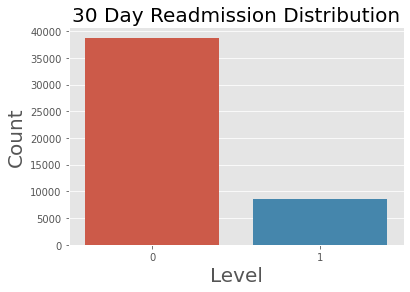

In [ ]:
b = sns.countplot(x = '30_readmit', data = des_mat)
b.axes.set_title('30 Day Readmission Distribution', fontsize = 20)
b.set_xlabel('Level', fontsize = 20)
b.set_ylabel('Count', fontsize = 20)
plt.show()

In [ ]:
full_index = np.random.permutation(np.arange(des_mat.shape[0]))
sub_index = full_index[:500]
draw_df = des_mat.iloc[sub_index, :]
draw_df = draw_df.drop(['hadm_id'], axis=1)
draw_df.loc[draw_df['30_readmit']==0, '30_readmit'] = 'N'
draw_df.loc[draw_df['30_readmit']==1, '30_readmit'] = 'Y'
draw_num_df = pd.concat((draw_df['30_readmit'], draw_df.iloc[:, 27:33]), axis=1)

In [ ]:
draw_df

subject_id_x           admittime           dischtime  admittime_rank  \
46231      13659269 2121-12-27 16:47:00 2122-01-02 16:10:00               4   
24728      12978689 2165-04-11 19:16:00 2165-04-14 13:56:00               2   
42853      15630181 2147-01-31 16:29:00 2147-02-03 16:45:00               8   
41191      19845148 2145-02-05 02:23:00 2145-02-28 18:45:00               5   
19422      13411956 2188-10-27 23:28:00 2188-11-03 18:11:00               1   
...             ...                 ...                 ...             ...   
39603      10457963 2124-09-30 16:12:00 2124-11-09 18:41:00               4   
7560       17085718 2124-10-06 16:47:00 2124-10-18 16:42:00               1   
21312      15349413 2141-08-01 18:38:00 2141-08-25 13:12:00               1   
29666      18418794 2146-11-06 02:34:00 2146-11-21 15:16:00               1   
39454      19667819 2125-01-12 17:24:00 2125-01-17 18:00:00               6   

       subject_id_1  max_admittime_rank      next_admittime 30_readmit  \
46231      13659269                  16 2122-11-12 15:24:00          N   
24728      12978689                   2 2139-02-02 21:34:00          N   
42853      15630181                   9 2147-12-28 02:59:00          N   
41191      19845148                   7 2145-03-06 02:24:00          Y   
19422      13411956                   2 2190-05-15 21:07:00          N   
...             ...                 ...                 ...        ...   
39603      10457963                   6 2124-11-17 21:34:00          Y   
7560       17085718                   1 2189-01-07 15:51:00          N   
21312      15349413                   2 2141-12-06 19:01:00          N   
29666      18418794                   3 2146-12-21 22:29:00          Y   
39454      19667819                   6 2131-09-24 21:21:00          N   

       interval  insurance_Medicaid  ...  mild_liver_disease  \
46231     313.0                   0  ...                   0   
24728       NaN                   0  ...                   0   
42853     327.0                   0  ...                   1   
41191       5.0                   0  ...                   0   
19422     558.0                   0  ...                   0   
...         ...                 ...  ...                 ...   
39603       8.0                   0  ...                   1   
7560        NaN                   0  ...                   0   
21312     103.0                   0  ...                   0   
29666      30.0                   0  ...                   0   
39454       NaN                   0  ...                   0   

       diabetes_without_cc  diabetes_with_cc  paraplegia  renal_disease  \
46231                    1                 1           0              0   
24728                    0                 0           0              0   
42853                    0                 0           0              0   
41191                    0                 0           0              0   
19422                    0                 0           0              0   
...                    ...               ...         ...            ...   
39603                    1                 0           0              0   
7560                     0                 0           0              0   
21312                    0                 0           0              0   
29666                    0                 0           0              0   
39454                    0                 0           0              0   

       malignant_cancer  severe_liver_disease  metastatic_solid_tumor  aids  \
46231                 0                     0                       0     0   
24728                 0                     0                       0     0   
42853                 0                     0                       0     0   
41191                 0                     0                       0     0   
19422                 0                     0                       0     0   
...                 ...  

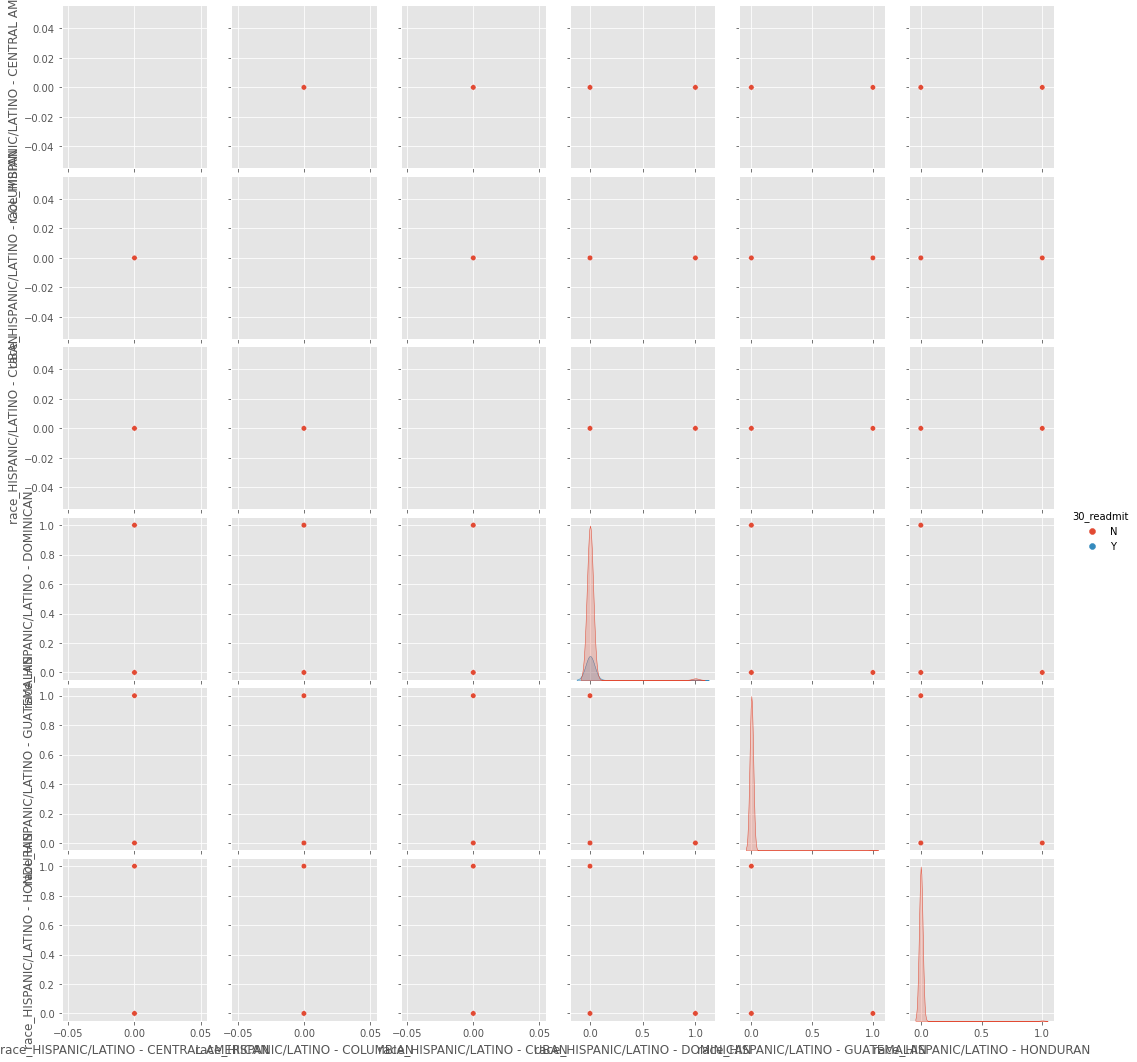

In [ ]:
num_feat_plot = sns.pairplot(draw_num_df, hue='30_readmit', plot_kws=dict(s=30))

In [ ]:
des_mat = des_mat.drop(columns=['admittime','dischtime','next_admittime','subject_id_1','interval'])

In [ ]:
test = des_mat.dropna()

In [ ]:
test.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47238 entries, 0 to 47237
Data columns (total 115 columns):
 #    Column                                                           Dtype  
---   ------                                                           -----  
 0    subject_id_x                                                     Int64  
 1    hadm_id                                                          Int64  
 2    admittime_rank                                                   Int64  
 3    max_admittime_rank                                               Int64  
 4    30_readmit                                                       int64  
 5    insurance_Medicaid                                               uint8  
 6    insurance_Medicare                                               uint8  
 7    insurance_Other                                                  uint8  
 8    marital_status_DIVORCED                                          uint8  
 9    marital_status_

In [ ]:
test.describe(include='all').T


count unique  top freq             mean  \
subject_id_x                47238.0    NaN  NaN  NaN  14978263.562915   
hadm_id                     47238.0    NaN  NaN  NaN  24980791.974046   
admittime_rank              47238.0    NaN  NaN  NaN         2.660295   
max_admittime_rank          47238.0    NaN  NaN  NaN         4.243363   
30_readmit                  47238.0    NaN  NaN  NaN         0.179516   
...                             ...    ...  ...  ...              ...   
malignant_cancer            47238.0    NaN  NaN  NaN         0.126529   
severe_liver_disease        47238.0    NaN  NaN  NaN         0.061963   
metastatic_solid_tumor      47238.0    NaN  NaN  NaN         0.060841   
aids                        47238.0    NaN  NaN  NaN         0.005631   
charlson_comorbidity_index  47238.0    NaN  NaN  NaN         4.732249   

                                       std         min          25%  \
subject_id_x                2883082.959128  10001725.0  12472690.25   
hadm_id                      2883884.43064  20000094.0   22476532.0   
admittime_rank                    3.959572         1.0          1.0   
max_admittime_rank                6.424689         1.0          1.0   
30_readmit                        0.383788         0.0          0.0   
...                                    ...         ...          ...   
malignant_cancer                  0.332449         0.0          0.0   
severe_liver_disease              0.241091         0.0          0.0   
metastatic_solid_tumor            0.239041         0.0          0.0   
aids                               0.07483         0.0          0.0   
charlson_comorbidity_index        2.973073         0.0          3.0   

                                   50%         75%         max  
subject_id_x                14972735.0  17481399.5  19999987.0  
hadm_id                     24978981.5  27465060.5  29999828.0  
admittime_rank                     1.0         3.0       228.0  
max_admittime_rank                 2.0         5.0       238.0  
30_readmit                         0.0         0.0         1.0  
...                                ...         ...         ...  
malignant_cancer                   0.0         0.0         1.0  
severe_liver_disease               0.0         0.0         1.0  
metastatic_solid_tumor             0.0         0.0         1.0  
aids                               0.0         0.0         1.0  
charlson_comorbidity_index         4.0         7.0        19.0  

[115 rows x 11 columns]

In [ ]:
test['urine_mean'] = test['urine_mean'].astype('float')


In [ ]:
test.isnull().sum()


subject_id_x                  0
hadm_id                       0
admittime_rank                0
max_admittime_rank            0
30_readmit                    0
                             ..
malignant_cancer              0
severe_liver_disease          0
metastatic_solid_tumor        0
aids                          0
charlson_comorbidity_index    0
Length: 115, dtype: int64

## Running Initial Pandas Profiling (After Prelim Data Cleaning)

In [ ]:
del criteria_df
del readmit_df
del readmit_label_df
del comorbid_df
del catfeat_df

In [ ]:
del all_readmit_data
del chev_df
del criteria_df_subet
del criteria_ids
del draw_df
del next_admittime
del numfeat_df
del readmit_sub_df

In [ ]:
del full_index
del interval
del le_df
del draw_num_df
del opev_df
del sub_index

In [ ]:
#df.to_csv('30_day_readmit_ML_df.csv')

In [ ]:
#import pandas as pd
#test= pd.read_csv('30_day_readmit_ML_df.csv')

In [ ]:
#sample = des_mat.sample(10000)

profile = ProfileReport(test, minimal=True)

In [ ]:
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Running Initial LazyPredict Classifier Models

In [ ]:
import lazypredict

In [ ]:
test2=test.sample(n=4000)

In [ ]:
X = test2.loc[:, test2.columns != '30_readmit']
y= test2['30_readmit']

In [ ]:
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split

#data = test
#X = test.loc[:, test.columns != '30_readmit']
#y= test['30_readmit']

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.3,random_state =123)

#split into training, testing, validation
#X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(test, target = '30_readmit',
#                                                                            train_size=0.7, valid_size=0.15, test_size=0.15)



In [ ]:
del X_test
del X_train
del X_valid
del y_test
del y_train
del y_valid
del des_mat

In [ ]:
clf = LazyClassifier()
models,predictions = clf.fit(X_train, X_test, y_train, y_test)

100%|██████████| 29/29 [00:13<00:00,  2.13it/s]


In [ ]:
print(models)

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
DecisionTreeClassifier             0.81               0.67     0.67      0.81   
XGBClassifier                      0.82               0.61     0.61      0.80   
Perceptron                         0.79               0.60     0.60      0.78   
LGBMClassifier                     0.82               0.59     0.59      0.80   
BaggingClassifier                  0.81               0.59     0.59      0.79   
NearestCentroid                    0.66               0.58     0.58      0.69   
AdaBoostClassifier                 0.82               0.57     0.57      0.79   
SGDClassifier                      0.78               0.56     0.56      0.76   
LinearDiscriminantAnalysis         0.82               0.56     0.56      0.79   
LogisticRegression                 0.83               0.56     0.56      0.79   
BernoulliNB                 

## Futher data cleaning

In [ ]:
X = test.loc[:, test.columns != '30_readmit']
y= test['30_readmit']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.3,random_state =123)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
features = list(X_train.columns)
rf = RandomForestClassifier(random_state=0)
rf.fit(X_train,y_train)

RandomForestClassifier(random_state=0)

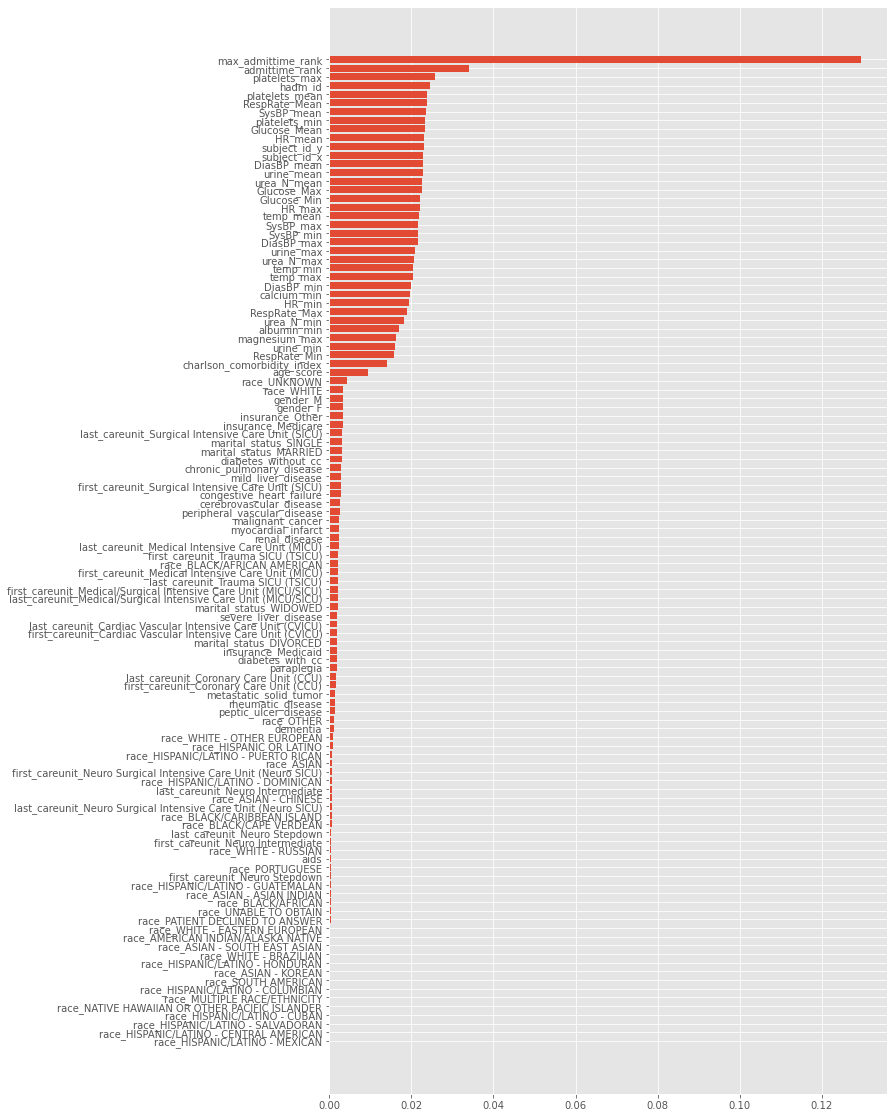

In [ ]:
f_i = list(zip(features,rf.feature_importances_))
f_i.sort(key = lambda x : x[1])
plt.figure(figsize=(10, 20))  # width:20, height:3
plt.barh([x[0] for x in f_i],[x[1] for x in f_i])


plt.show()

In [ ]:
feature_importances = pd.DataFrame(rf.feature_importances_, index =features,  columns=['importance']).sort_values('importance', ascending=False)

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(feature_importances)

                                                    importance
max_admittime_rank                                    0.129506
admittime_rank                                        0.034020
platelets_max                                         0.025643
hadm_id                                               0.024617
platelets_mean                                        0.023772
RespRate_Mean                                         0.023691
SysBP_mean                                            0.023651
platelets_min                                         0.023336
Glucose_Mean                                          0.023269
HR_mean                                               0.023093
subject_id_y                                          0.023002
subject_id_x                                          0.022854
DiasBP_mean                                           0.022801
urine_mean                                            0.022759
urea_N_mean                                           0

In [ ]:
feature_df = feature_importances[feature_importances['importance'] > 0.01]
selected_features = list(feature_df.index)
selected_features.append("30_readmit")

In [ ]:
print(test.columns.intersection(selected_features))


Index(['subject_id_x', 'hadm_id', 'admittime_rank', 'max_admittime_rank',
       '30_readmit', 'urea_N_min', 'urea_N_max', 'urea_N_mean',
       'platelets_min', 'platelets_max', 'platelets_mean', 'magnesium_max',
       'albumin_min', 'calcium_min', 'urine_min', 'urine_max', 'urine_mean',
       'RespRate_Min', 'RespRate_Max', 'RespRate_Mean', 'Glucose_Min',
       'Glucose_Max', 'Glucose_Mean', 'HR_min', 'HR_max', 'HR_mean',
       'SysBP_min', 'SysBP_max', 'SysBP_mean', 'DiasBP_min', 'DiasBP_max',
       'DiasBP_mean', 'temp_min', 'temp_max', 'temp_mean', 'subject_id_y',
       'charlson_comorbidity_index'],
      dtype='object')


In [ ]:
df_after_fs = test[test.columns.intersection(selected_features)]

In [ ]:
#subset our original dataframe after feature selection with features with importance > 0
df_after_fs

subject_id_x   hadm_id  admittime_rank  max_admittime_rank  30_readmit  \
0          10670085  24126885               2                  26           1   
1          10670085  24164808               3                  26           0   
2          10670085  26806734               4                  26           0   
3          10670085  29621243               9                  26           1   
4          10670085  23682829              11                  26           0   
...             ...       ...             ...                 ...         ...   
47233      18991843  25884420              12                  22           0   
47234      18991843  25113992              16                  22           1   
47235      18991843  29400945              22                  22           0   
47236      18369403  23270486              17                  22           1   
47237      11068569  29173107               3                  22           1   

       urea_N_min  urea_N_max  urea_N_mean  platelets_min  platelets_max  ...  \
0            18.0        31.0    24.333333          202.0          218.0  ...   
1            21.0        29.0    25.571429          176.0          215.0  ...   
2            22.0        32.0    25.800000          111.0          216.0  ...   
3            22.0        43.0    31.333333          170.0          296.0  ...   
4            12.0        32.0    15.437500          162.0          328.0  ...   
...           ...         ...          ...            ...            ...  ...   
47233        15.0        65.0    28.219512           72.0          449.0  ...   
47234        37.0        80.0    52.444444          279.0          431.0  ...   
47235        97.0       120.0   105.250000           46.0          112.0  ...   
47236        10.0        25.0    14.363636          142.0          296.0  ...   
47237        34.0        48.0    41.937500          192.0          287.0  ...   

       SysBP_max  SysBP_mean  DiasBP_min  DiasBP_max  DiasBP_mean   temp_min  \
0          122.0      105.00        33.0        77.0        49.22  36.277778   
1          156.0      109.12        29.0        79.0        48.39  35.777778   
2          156.0      103.52        23.0        76.0        43.83  35.888889   
3          138.0       97.55        31.0        97.0        51.95  36.555556   
4          134.0      103.16        33.0        91.0        47.82  36.611111   
...          ...         ...         ...         ...          ...        ...   
47233      206.0      140.22        27.0       148.0        55.48  36.111111   
47234      145.0      123.47        47.0        92.0        60.76  36.277778   
47235      160.0      126.88        45.0       101.0        62.17  36.200000   
47236      156.0      118.79        29.0        88.0        64.16  36.444444   
47237      144.0      124.04        39.0        82.0        58.21  36.277778   

        temp_max  temp_mean  subject_id_y  charlson_comorbidity_index  
0      38.722222      37.38      10670085                           6  
1      36.888889      36.49      10670085                           5  
2      38.700000      37.37      10670085                           5  
3      37.888889      37.29      10670085                           5  
4      37.444444      36.86      10670085                           5  
...          ...        ...           ...                         ...  
47233  38.222222      36.90      18991843                           8  
47234  37.055556      36.68      18991843                          12  
47235  37.900000      36.91      18991843                          10  
47236  37.277778      36.85      18369403                           9  
47237  37.777778      36.63      11068569                           1  

[47238 rows x 37 columns]

In [ ]:
# trying models again after features selection to see what is best

In [ ]:
df_after_fs

subject_id_x   hadm_id  admittime_rank  max_admittime_rank  30_readmit  \
0          10670085  24126885               2                  26           1   
1          10670085  24164808               3                  26           0   
2          10670085  26806734               4                  26           0   
3          10670085  29621243               9                  26           1   
4          10670085  23682829              11                  26           0   
...             ...       ...             ...                 ...         ...   
47233      18991843  25884420              12                  22           0   
47234      18991843  25113992              16                  22           1   
47235      18991843  29400945              22                  22           0   
47236      18369403  23270486              17                  22           1   
47237      11068569  29173107               3                  22           1   

       urea_N_min  urea_N_max  urea_N_mean  platelets_min  platelets_max  ...  \
0            18.0        31.0    24.333333          202.0          218.0  ...   
1            21.0        29.0    25.571429          176.0          215.0  ...   
2            22.0        32.0    25.800000          111.0          216.0  ...   
3            22.0        43.0    31.333333          170.0          296.0  ...   
4            12.0        32.0    15.437500          162.0          328.0  ...   
...           ...         ...          ...            ...            ...  ...   
47233        15.0        65.0    28.219512           72.0          449.0  ...   
47234        37.0        80.0    52.444444          279.0          431.0  ...   
47235        97.0       120.0   105.250000           46.0          112.0  ...   
47236        10.0        25.0    14.363636          142.0          296.0  ...   
47237        34.0        48.0    41.937500          192.0          287.0  ...   

       SysBP_max  SysBP_mean  DiasBP_min  DiasBP_max  DiasBP_mean   temp_min  \
0          122.0      105.00        33.0        77.0        49.22  36.277778   
1          156.0      109.12        29.0        79.0        48.39  35.777778   
2          156.0      103.52        23.0        76.0        43.83  35.888889   
3          138.0       97.55        31.0        97.0        51.95  36.555556   
4          134.0      103.16        33.0        91.0        47.82  36.611111   
...          ...         ...         ...         ...          ...        ...   
47233      206.0      140.22        27.0       148.0        55.48  36.111111   
47234      145.0      123.47        47.0        92.0        60.76  36.277778   
47235      160.0      126.88        45.0       101.0        62.17  36.200000   
47236      156.0      118.79        29.0        88.0        64.16  36.444444   
47237      144.0      124.04        39.0        82.0        58.21  36.277778   

        temp_max  temp_mean  subject_id_y  charlson_comorbidity_index  
0      38.722222      37.38      10670085                           6  
1      36.888889      36.49      10670085                           5  
2      38.700000      37.37      10670085                           5  
3      37.888889      37.29      10670085                           5  
4      37.444444      36.86      10670085                           5  
...          ...        ...           ...                         ...  
47233  38.222222      36.90      18991843                           8  
47234  37.055556      36.68      18991843                          12  
47235  37.900000      36.91      18991843                          10  
47236  37.277778      36.85      18369403                           9  
47237  37.777778      36.63      11068569                           1  

[47238 rows x 37 columns]

In [ ]:
#subset to remove 20% to use as final validation
df_valid_holdout = df_after_fs.sample(n=3989, random_state=42)
df_valid_holdout

subject_id_x   hadm_id  admittime_rank  max_admittime_rank  30_readmit  \
28875      10071302  27168465               2                   3           0   
44211      10585182  21012865               1                  11           1   
36168      15143536  28819547               1                   5           1   
5881       14343751  29469823               1                   1           0   
10781      15416400  21051906               1                   1           0   
...             ...       ...             ...                 ...         ...   
8525       10948492  25295687               1                   1           0   
29368      15321868  29922171               1                   3           1   
19714      16709726  25000205               1                   2           1   
12597      13909974  22193678               1                   1           0   
36890      17142154  29440122               1                   5           1   

       urea_N_min  urea_N_max  urea_N_mean  platelets_min  platelets_max  ...  \
28875         5.0         9.0     6.750000          627.0          878.0  ...   
44211         7.0        30.0    15.800000          143.0          330.0  ...   
36168        23.0        52.0    31.000000           73.0          161.0  ...   
5881         12.0        20.0    16.166667          106.0          221.0  ...   
10781        18.0       104.0    65.333333           91.0          205.0  ...   
...           ...         ...          ...            ...            ...  ...   
8525          4.0         8.0     6.333333          240.0          304.0  ...   
29368         7.0        39.0    16.272727           95.0          436.0  ...   
19714        12.0        20.0    16.888889          156.0          235.0  ...   
12597        15.0        44.0    23.684211          297.0          581.0  ...   
36890        19.0        39.0    30.900000          715.0          866.0  ...   

       SysBP_max  SysBP_mean  DiasBP_min  DiasBP_max  DiasBP_mean   temp_min  \
28875      165.0      111.99        35.0        74.0        49.14  35.722222   
44211      145.0      108.94        37.0       104.0        57.52  35.888889   
36168      186.0      125.36        35.0       100.0        56.25  35.000000   
5881       225.0      114.92        48.0       127.0        69.47  35.222222   
10781      158.0      107.45        12.0       122.0        60.71  35.000000   
...          ...         ...         ...         ...          ...        ...   
8525       110.0       98.96        35.0        66.0        44.40  35.666667   
29368      150.0      116.77        45.0       101.0        71.30  35.666667   
19714      160.0      107.99        49.0       139.0        69.32  35.300000   
12597      131.0      108.70        47.0        74.0        59.22  36.444444   
36890      140.0      117.36        45.0        89.0        65.51  36.555556   

        temp_max  temp_mean  subject_id_y  charlson_comorbidity_index  
28875  39.444444      37.16      10071302                           5  
44211  38.500000      37.03      10585182                           4  
36168  38.777778      36.54      15143536                           8  
5881   37.888889      36.24      14343751                           1  
10781  38.000000      36.17      15416400                           5  
...          ...        ...           ...                         ...  
8525   37.055556      36.28      10948492                           2  
29368  36.888889      36.25      15321868                           4  
19714  37.600000      36.92      16709726                           4  
12597  37.333333      36.86      13909974                           3  
36890  37.500000      37.04      17142154                           4  

[3989 rows x 37 columns]

In [ ]:
# the remainig 80% of data left over that I will use for GridSearchCV
holdout_rows = list(df_valid_holdout.index)
total_df = df_after_fs[~df_after_fs.index.isin(holdout_rows)]
#total df is the one we will use for gridesearchcv

In [ ]:
total_df

subject_id_x   hadm_id  admittime_rank  max_admittime_rank  30_readmit  \
0          10670085  24126885               2                  26           1   
1          10670085  24164808               3                  26           0   
2          10670085  26806734               4                  26           0   
3          10670085  29621243               9                  26           1   
5          10670085  23682829              11                  26           0   
...             ...       ...             ...                 ...         ...   
47233      18991843  25884420              12                  22           0   
47234      18991843  25113992              16                  22           1   
47235      18991843  29400945              22                  22           0   
47236      18369403  23270486              17                  22           1   
47237      11068569  29173107               3                  22           1   

       urea_N_min  urea_N_max  urea_N_mean  platelets_min  platelets_max  ...  \
0            18.0        31.0    24.333333          202.0          218.0  ...   
1            21.0        29.0    25.571429          176.0          215.0  ...   
2            22.0        32.0    25.800000          111.0          216.0  ...   
3            22.0        43.0    31.333333          170.0          296.0  ...   
5            12.0        32.0    15.437500          162.0          328.0  ...   
...           ...         ...          ...            ...            ...  ...   
47233        15.0        65.0    28.219512           72.0          449.0  ...   
47234        37.0        80.0    52.444444          279.0          431.0  ...   
47235        97.0       120.0   105.250000           46.0          112.0  ...   
47236        10.0        25.0    14.363636          142.0          296.0  ...   
47237        34.0        48.0    41.937500          192.0          287.0  ...   

       SysBP_max  SysBP_mean  DiasBP_min  DiasBP_max  DiasBP_mean   temp_min  \
0          122.0      105.00        33.0        77.0        49.22  36.277778   
1          156.0      109.12        29.0        79.0        48.39  35.777778   
2          156.0      103.52        23.0        76.0        43.83  35.888889   
3          138.0       97.55        31.0        97.0        51.95  36.555556   
5          134.0      103.16        33.0        91.0        47.82  36.611111   
...          ...         ...         ...         ...          ...        ...   
47233      206.0      140.22        27.0       148.0        55.48  36.111111   
47234      145.0      123.47        47.0        92.0        60.76  36.277778   
47235      160.0      126.88        45.0       101.0        62.17  36.200000   
47236      156.0      118.79        29.0        88.0        64.16  36.444444   
47237      144.0      124.04        39.0        82.0        58.21  36.277778   

        temp_max  temp_mean  subject_id_y  charlson_comorbidity_index  
0      38.722222      37.38      10670085                           6  
1      36.888889      36.49      10670085                           5  
2      38.700000      37.37      10670085                           5  
3      37.888889      37.29      10670085                           5  
5      37.444444      36.86      10670085                           5  
...          ...        ...           ...                         ...  
47233  38.222222      36.90      18991843                           8  
47234  37.055556      36.68      18991843                          12  
47235  37.900000      36.91      18991843                          10  
47236  37.277778      36.85      18369403                           9  
47237  37.777778      36.63      11068569                           1  

[43249 rows x 37 columns]

In [ ]:
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split

#data = test
X = total_df.loc[:, total_df.columns != '30_readmit']
y = total_df['30_readmit']

#X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.3,random_state =123)

#split into training, testing, validation
#X_train, y_train, X_test, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2,random_state=42)
test_size = 0.3 # Set the percentage of data for testing
train_df, test_df = train_test_split(total_df, test_size=test_size, random_state=42)

X_train = train_df.drop('30_readmit', axis=1) # Features for training
y_train = train_df['30_readmit'] # Target variable for training

X_test = test_df.drop('30_readmit', axis=1) # Features for testing
y_test = test_df['30_readmit'] # Target variable for testing

In [ ]:
X_train.shape
y_train.shape
X_test.shape
y_test.shape

(12975,)

In [ ]:
#del df_after_fs
#del holdout_rows
#del test
#del test2
del clf

In [ ]:
clf = LazyClassifier()
models,predictions = clf.fit(X_train, X_test, y_train, y_test)

100%|██████████| 29/29 [05:24<00:00, 11.20s/it]


In [ ]:
print(models)

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
DecisionTreeClassifier             0.83               0.71     0.71      0.83   
ExtraTreeClassifier                0.79               0.65     0.65      0.79   
BaggingClassifier                  0.84               0.65     0.65      0.82   
XGBClassifier                      0.84               0.65     0.65      0.82   
NearestCentroid                    0.70               0.63     0.63      0.73   
LabelSpreading                     0.78               0.61     0.61      0.77   
LabelPropagation                   0.78               0.61     0.61      0.77   
LGBMClassifier                     0.84               0.61     0.61      0.81   
RandomForestClassifier             0.85               0.60     0.60      0.81   
ExtraTreesClassifier               0.85               0.59     0.59      0.80   
PassiveAggressiveClassifier 

In [ ]:
# 5 models to use: ExtraTreesClassifier, LGBMClassifier, XGBClassifier, NuSVC, BaggingClassifier

## ExtraTreesClassifier

In [ ]:
import numpy as np

from sklearn.model_selection import GridSearchCV

class EstimatorSelectionHelper:

    def __init__(self, models, params):
        if not set(models.keys()).issubset(set(params.keys())):
            missing_params = list(set(models.keys()) - set(params.keys()))
            raise ValueError("Some estimators are missing parameters: %s" % missing_params)
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv=3, n_jobs=3, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print("Running GridSearchCV for %s." % key)
            model = self.models[key]
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, refit=refit,
                              return_train_score=True)
            gs.fit(X,y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                 'estimator': key,
                 'min_score': min(scores),
                 'max_score': max(scores),
                 'mean_score': np.mean(scores),
                 'std_score': np.std(scores),
            }
            return pd.Series({**params,**d})

        rows = []
        for k in self.grid_searches:
            print(k)
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params),1))

            all_scores = np.hstack(scores)
            for p, s in zip(params,all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns]

In [ ]:
#Common Model Algorithms
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier

#Common Model Helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

#Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#Machine Learning Algorithm (MLA) Selection and Initialization
MLA = [
    #Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),

    #Gaussian Processes
    gaussian_process.GaussianProcessClassifier(),

    #GLM
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model.SGDClassifier(),

    #Trees
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),

    #Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),


    #xgboost: http://xgboost.readthedocs.io/en/latest/model.html
    XGBClassifier()
    ]



#split dataset in cross-validation with this splitter class: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html#sklearn.model_selection.ShuffleSplit
#note: this is an alternative to train_test_split
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0 ) # run model 10x with 60/30 split intentionally leaving out 10%

#create table to compare MLA metrics
MLA_columns = ['MLA Name', 'MLA Parameters','MLA Train Accuracy Mean', 'MLA Test Accuracy Mean', 'MLA Test Accuracy 3*STD' ,'MLA Time']
MLA_compare = pd.DataFrame(columns = MLA_columns)

#create table to compare MLA predictions
MLA_predict = X_test

#index through MLA and save performance to table
row_index = 0
for alg in MLA:

    #set name and parameters
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())

    #score model with cross validation: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
    cv_results = model_selection.cross_validate(alg, X, y, cv  = cv_split,return_train_score=True)

    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()
    #if this is a non-bias random sample, then +/-3 standard deviations (std) from the mean, should statistically capture 99.7% of the subsets
    MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std()*3   #let's know the worst that can happen!


    #save MLA predictions - see section 6 for usage
    alg.fit(X,y)
    MLA_predict = alg.predict(X_test)

    row_index+=1


#print and sort table: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sort_values.html
MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)
MLA_compare
#MLA_predict

## PassiveAggressiveClassifier

In [ ]:
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV

parameter_candidates= {
                       'C' : [0, 0.5, 0.75, 1],
                       'loss' : ['hinge','squared_hinge']}

pac_clf = GridSearchCV(estimator=PassiveAggressiveClassifier(),
                    param_grid=parameter_candidates,
                    cv=5,
                    refit=True,
                    error_score=0,
                    n_jobs=-1
                    )

pac_clf.fit(X, y)
# print best parameter after tuning
print(pac_clf.best_params_)
pac_clf_predictions = pac_clf.predict(X_test)

{'C': 0.5, 'loss': 'squared_hinge'}


In [ ]:
print('Train Accuracy : %.3f'%pac_clf.best_estimator_.score(X_train, y_train))
print('Test Accuracy : %.3f'%pac_clf.best_estimator_.score(X_test, y_test))
print('Best Accuracy Through Grid Search : %.3f'%pac_clf.best_score_)
print('Best Parameters : ',pac_clf.best_params_)

Train Accuracy : 0.821
Test Accuracy : 0.818
Best Accuracy Through Grid Search : 0.820
Best Parameters :  {'C': 0.5, 'loss': 'squared_hinge'}


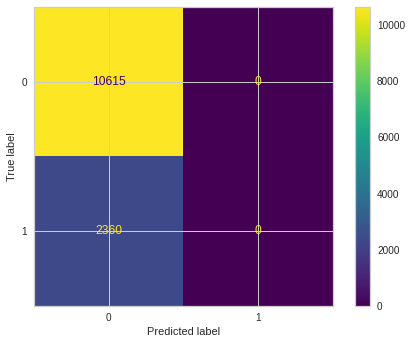

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


pac_cm = confusion_matrix(y_test, pac_clf_predictions, labels=pac_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=pac_cm,
                               display_labels=pac_clf.classes_)
disp.plot()
plt.show()

In [ ]:
tn, fp, fn, tp = pac_cm.ravel()
pac_os_sen = tp/(tp+fn)
pac_os_spe = tn/(tn+fp)
pac_os_prec = tp/(tp+fp)
pac_os_acc = (tp+tn)/(tp+tn+fp+fn)

## ExtraTreesClassifier

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.semi_supervised import LabelPropagation
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

parameter_candidates= {'n_estimators': [20, 50, 100], 'max_depth': [5,10,20]}
etc_clf = GridSearchCV(estimator=ExtraTreesClassifier(),
                    param_grid=parameter_candidates,
                    cv=5,
                    refit=True,
                    error_score=0,
                    n_jobs=-1)

etc_clf.fit(X, y)
# print best parameter after tuning
print(etc_clf.best_params_)
etc_clf_predictions = etc_clf.predict(X_test)

# print classification report
print(classification_report(y_test, etc_clf_predictions))


{'max_depth': 10, 'n_estimators': 50}
              precision    recall  f1-score   support

           0       0.82      1.00      0.90     10615
           1       1.00      0.01      0.01      2360

    accuracy                           0.82     12975
   macro avg       0.91      0.50      0.46     12975
weighted avg       0.85      0.82      0.74     12975



In [ ]:
print('Train Accuracy : %.3f'%etc_clf.best_estimator_.score(X_train, y_train))
print('Test Accuracy : %.3f'%etc_clf.best_estimator_.score(X_test, y_test))
print('Best Accuracy Through Grid Search : %.3f'%etc_clf.best_score_)
print('Best Parameters : ',etc_clf.best_params_)

Train Accuracy : 0.823
Test Accuracy : 0.819
Best Accuracy Through Grid Search : 0.820
Best Parameters :  {'max_depth': 10, 'n_estimators': 50}


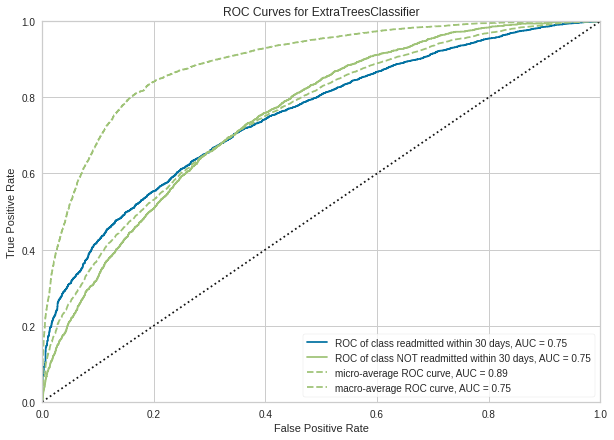

In [ ]:
from yellowbrick.classifier.rocauc import roc_auc, roc_curve

fig = plt.figure(figsize=(10,7))
ax1 = fig.add_subplot(111)
roc_auc(ExtraTreesClassifier(max_depth=10, n_estimators = 50),
        X_train, y_train,
        X_test, y_test,
        ax=ax1,
        classes = ['readmitted within 30 days','NOT readmitted within 30 days'],
        binary = False
        );

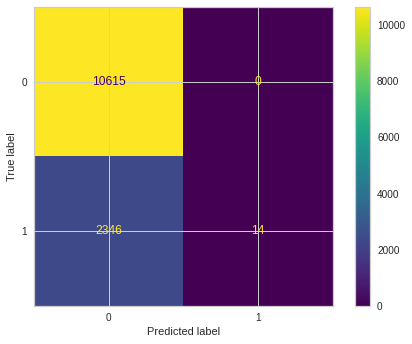

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


etc_cm = confusion_matrix(y_test, etc_clf_predictions, labels=etc_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=etc_cm,
                               display_labels=etc_clf.classes_)
disp.plot()
plt.show()

In [ ]:
tn, fp, fn, tp = etc_cm.ravel()
etc_os_sen = tp/(tp+fn)
etc_os_spe = tn/(tn+fp)
etc_os_prec = tp/(tp+fp)
etc_os_acc = (tp+tn)/(tp+tn+fp+fn)

## NearestCentroid

In [ ]:
from sklearn.neighbors import NearestCentroid
parameter_candidates= {'metric' : ['euclidean','cosine', 'cityblock','haversine','l1','l2','manhattan','nan_euclidean'],
                       'shrink_threshold': [0.1, 0.5, 0.9]}

nc_clf = GridSearchCV(estimator=NearestCentroid(),
                    param_grid=parameter_candidates,
                    cv=5,
                    refit=True,
                    error_score=0,
                    n_jobs=-1
                    )

nc_clf.fit(X, y)
# print best parameter after tuning
print(nc_clf.best_params_)
nc_clf_predictions = nc_clf.predict(X_test)

{'metric': 'cityblock', 'shrink_threshold': 0.9}


In [ ]:
print('Train Accuracy : %.3f'%nc_clf.best_estimator_.score(X_train, y_train))
print('Test Accuracy : %.3f'%nc_clf.best_estimator_.score(X_test, y_test))
print('Best Accuracy Through Grid Search : %.3f'%nc_clf.best_score_)
print('Best Parameters : ',nc_clf.best_params_)

Train Accuracy : 0.820
Test Accuracy : 0.816
Best Accuracy Through Grid Search : 0.749
Best Parameters :  {'metric': 'cityblock', 'shrink_threshold': 0.9}


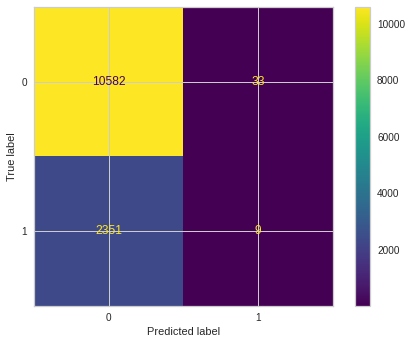

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


nc_cm = confusion_matrix(y_test, nc_clf_predictions, labels=nc_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=nc_cm,
                               display_labels=nc_clf.classes_)
disp.plot()
plt.show()

In [ ]:
tn, fp, fn, tp = nc_cm.ravel()
nc_os_sen = tp/(tp+fn)
nc_os_spe = tn/(tn+fp)
nc_os_prec = tp/(tp+fp)
nc_os_acc = (tp+tn)/(tp+tn+fp+fn)

## XGBClassifier

In [ ]:
from xgboost import XGBClassifier

parameter_candidates= {'booster' : ['gbtree','gblinear', 'dart'],
                       'n_estimators': [20, 50, 100]}
xgb_clf = GridSearchCV(estimator=XGBClassifier(),
                    param_grid=parameter_candidates,
                    cv=5,
                    refit=True,
                    error_score=0,
                    n_jobs=-1)

xgb_clf.fit(X, y)
# print best parameter after tuning
print(xgb_clf.best_params_)
xgb_clf_predictions = xgb_clf.predict(X_test)

# print classification report
print(classification_report(y_test, xgb_clf_predictions))


{'booster': 'gblinear', 'n_estimators': 20}
              precision    recall  f1-score   support

           0       0.83      0.98      0.90     10615
           1       0.54      0.08      0.14      2360

    accuracy                           0.82     12975
   macro avg       0.68      0.53      0.52     12975
weighted avg       0.78      0.82      0.76     12975



In [ ]:
print('Train Accuracy : %.3f'%xgb_clf.best_estimator_.score(X_train, y_train))
print('Test Accurqacy : %.3f'%xgb_clf.best_estimator_.score(X_test, y_test))
print('Best Accuracy Through Grid Search : %.3f'%xgb_clf.best_score_)
print('Best Parameters : ',xgb_clf.best_params_)

Train Accuracy : 0.823
Test Accurqacy : 0.820
Best Accuracy Through Grid Search : 0.821
Best Parameters :  {'booster': 'gblinear', 'n_estimators': 20}


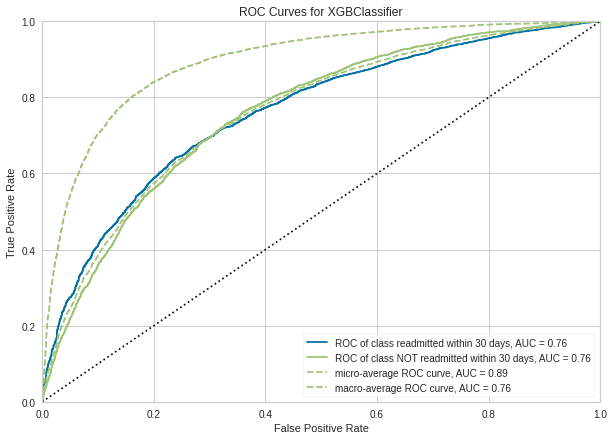

In [ ]:
from yellowbrick.classifier.rocauc import roc_auc, roc_curve

fig = plt.figure(figsize=(10,7))
ax1 = fig.add_subplot(111)
roc_auc(XGBClassifier(booster='gblinear', n_estimators = 20),
        X_train, y_train,
        X_test, y_test,
        ax=ax1,
        classes = ['readmitted within 30 days','NOT readmitted within 30 days'],
        binary = False
        );

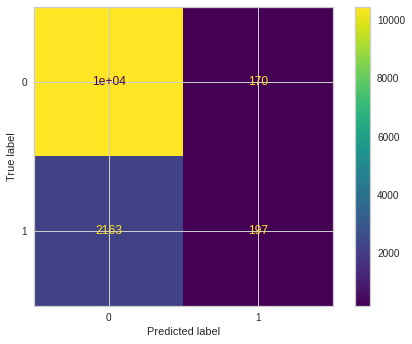

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


xgb_cm = confusion_matrix(y_test, xgb_clf_predictions, labels=xgb_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=xgb_cm,
                               display_labels=xgb_clf.classes_)
disp.plot()
plt.show()

In [ ]:
tn, fp, fn, tp = xgb_cm.ravel()
xgb_os_sen = tp/(tp+fn)
xgb_os_spe = tn/(tn+fp)
xgb_os_prec = tp/(tp+fp)
xgb_os_acc = (tp+tn)/(tp+tn+fp+fn)

## RandomForestClassifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

parameter_candidates= {'max_features': ['auto', 'sqrt', 'log2'],
                       'criterion' :['gini', 'entropy'],
                      'n_estimators': [300, 500, 700],
                       'max_depth' : [4,5,6,7,8]}
rf_clf = GridSearchCV(estimator=RandomForestClassifier(n_jobs=-1),
                    param_grid=parameter_candidates,
                    cv=5,
                    refit=True,
                    error_score=0)

rf_clf.fit(X, y)
# print best parameter after tuning
print(rf_clf.best_params_)
rf_clf_predictions = rf_clf.predict(X_test)

# print classification report
print(classification_report(y_test, rf_clf_predictions))


{'criterion': 'entropy', 'max_depth': 4, 'max_features': 'log2', 'n_estimators': 300}
              precision    recall  f1-score   support

           0       0.82      1.00      0.90     10615
           1       0.00      0.00      0.00      2360

    accuracy                           0.82     12975
   macro avg       0.41      0.50      0.45     12975
weighted avg       0.67      0.82      0.74     12975



In [ ]:
print('Train Accuracy : %.3f'%rf_clf.best_estimator_.score(X_train, y_train))
print('Test Accuracy : %.3f'%rf_clf.best_estimator_.score(X_test, y_test))
print('Best Accuracy Through Grid Search : %.3f'%rf_clf.best_score_)
print('Best Parameters : ',rf_clf.best_params_)

Train Accuracy : 0.821
Test Accuracy : 0.818
Best Accuracy Through Grid Search : 0.819
Best Parameters :  {'criterion': 'entropy', 'max_depth': 4, 'max_features': 'log2', 'n_estimators': 300}


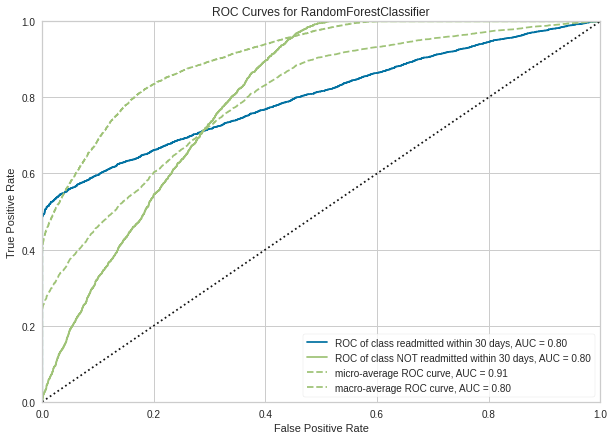

In [ ]:
from yellowbrick.classifier.rocauc import roc_auc, roc_curve
fig = plt.figure(figsize=(10,7))
ax1 = fig.add_subplot(111)

roc_auc(RandomForestClassifier(criterion= 'entropy', max_depth= 4, max_features= 'log2', n_estimators = 300),
        X_train, y_train,
        X_test, y_test,
        ax=ax1,
        classes = ['readmitted within 30 days','NOT readmitted within 30 days'],
        binary = False
        );

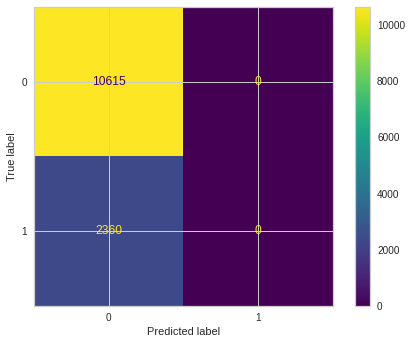

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


rf_cm = confusion_matrix(y_test, rf_clf_predictions, labels=rf_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=rf_cm,
                               display_labels=rf_clf.classes_)
disp.plot()
plt.show()

In [ ]:
tn, fp, fn, tp = rf_cm.ravel()
rf_os_sen = tp/(tp+fn)
rf_os_spe = tn/(tn+fp)
rf_os_prec = tp/(tp+fp)
rf_os_acc = (tp+tn)/(tp+tn+fp+fn)

In [ ]:
clf = ['PAC','ETC', 'NC', 'XGB', 'RF']
sen = [pac_os_sen, etc_os_sen, nc_os_sen, xgb_os_sen, rf_os_sen]
spe = [pac_os_spe, etc_os_spe, nc_os_spe, xgb_os_spe, rf_os_spe]
prec = [pac_os_prec, etc_os_prec, nc_os_prec, xgb_os_prec, rf_os_prec]
acc = [pac_os_acc, etc_os_acc, nc_os_acc, xgb_os_acc, rf_os_acc]

perf_dict = {'classifier': clf, 'sensitivity': sen, 'specificity':spe, 'precision': prec, 'accuracy':acc}

In [ ]:
draw_df = pd.DataFrame(perf_dict)
draw_melt_df = pd.melt(draw_df, id_vars=['classifier'])

<Figure size 2160x2160 with 0 Axes>

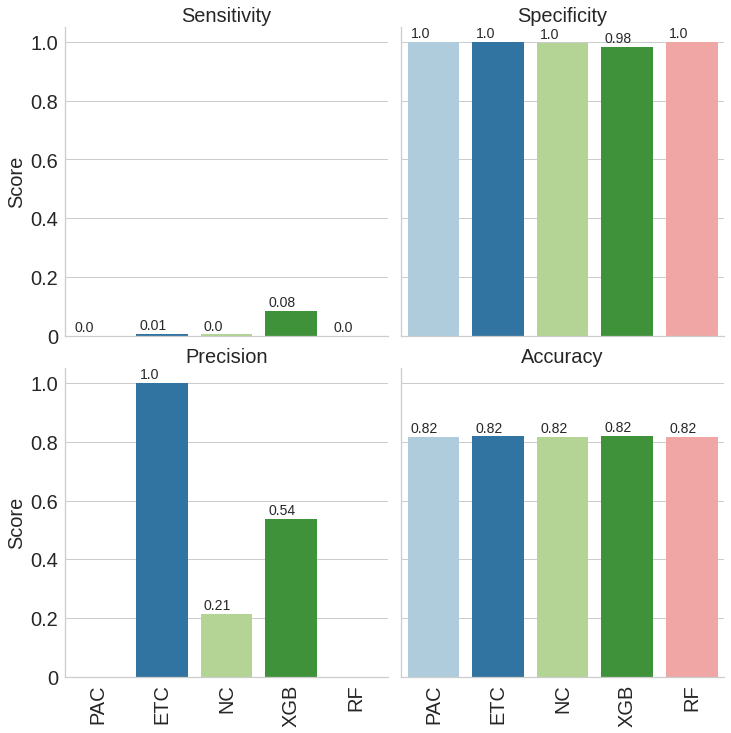

In [ ]:
fig = plt.figure(figsize=(30,30))
perf_plt = sns.catplot(x='classifier', y='value',col='variable', col_wrap=2,
                       kind='bar', data=draw_melt_df, palette=sns.color_palette('Paired'))
perf_plt.axes[0].set_title('Sensitivity', fontsize='20')
perf_plt.axes[1].set_title('Specificity', fontsize='20')
perf_plt.axes[2].set_title('Precision',fontsize='20')
perf_plt.axes[3].set_title('Accuracy',fontsize='20')
perf_plt.axes[2].set_xticklabels(labels= clf, rotation='vertical',fontdict={'size':20})
perf_plt.axes[3].set_xticklabels(labels= clf, rotation='vertical',fontdict={'size':20})
perf_plt.axes[2].set_xlabel('')
perf_plt.axes[3].set_xlabel('')
perf_plt.axes[0].set_ylabel('Score', fontsize='20')
perf_plt.axes[2].set_ylabel('Score', fontsize='20')
perf_plt.axes[0].set_yticklabels(labels=['0','0.2','0.4','0.6','0.8','1.0'], fontdict={'size':20})
perf_plt.axes[2].set_yticklabels(labels=['0','0.2','0.4','0.6','0.8','1.0'], fontdict={'size':20})
for index, row in draw_df.iterrows():
    perf_plt.axes[0].text(index-.35, row.sensitivity+.015, round(row.sensitivity,2), fontdict={'size':14})
    perf_plt.axes[1].text(index-.35, row.specificity+.015, round(row.specificity,2), fontdict={'size':14})
    perf_plt.axes[2].text(index-.35, row.precision+.015, round(row.precision,2), fontdict={'size':14})
    perf_plt.axes[3].text(index-.35, row.accuracy+.015, round(row.accuracy,2), fontdict={'size':14})